In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import obonet
from tqdm import tqdm
import warnings

import os
warnings.filterwarnings('ignore')

from Dataset.GoDataset import GOTermDataset, get_class_frequencies_from_dataframe
from Model.ProtienGOClassifier_pl import ProteinGOClassifierLightning
from Dataset.utils import prepare_data, read_fasta, prepare_data_range, submodular_term_selection

/home/tan/miniconda3/envs/cafa6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

BASE_PATH = "/mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction"


go_graph = obonet.read_obo(os.path.join(BASE_PATH, 'Train/go-basic.obo'))
print(f"Gene Ontology graph loaded with {len(go_graph)} nodes and {len(go_graph.edges)} edges.")

train_terms_df = pd.read_csv(os.path.join(BASE_PATH, 'Train/train_terms.tsv'), sep='\\t')
print(f"Training terms loaded. Shape: {train_terms_df.shape}")


train_fasta_path = os.path.join(BASE_PATH, 'Train/train_sequences.fasta')

test_fasta_path = os.path.join(BASE_PATH, 'Test/testsuperset.fasta')

ia_df = pd.read_csv(os.path.join(BASE_PATH, 'IA.tsv'), sep='\\t', header=None, names=['term_id', 'ia_score'])
ia_map = dict(zip(ia_df['term_id'], ia_df['ia_score']))
print(train_terms_df['aspect'].value_counts().reset_index())

train_seq = read_fasta(train_fasta_path)
test_seq = read_fasta(test_fasta_path)

Gene Ontology graph loaded with 40122 nodes and 77229 edges.
Training terms loaded. Shape: (537027, 3)
  aspect   count
0      P  250805
1      C  157770
2      F  128452
[io] Read 82404 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Train/train_sequences.fasta
[io] Read 224309 sequences from /mnt/d/ML/Kaggle/CAFA6/cafa-6-protein-function-prediction/Test/testsuperset.fasta


In [8]:
arr, top_terms, _ = submodular_term_selection(train_terms_df, 64)
data = {}
data['train_labels'] = arr
data['top_terms'] = top_terms

100%|██████████| 64/64 [00:02<00:00, 26.98it/s]


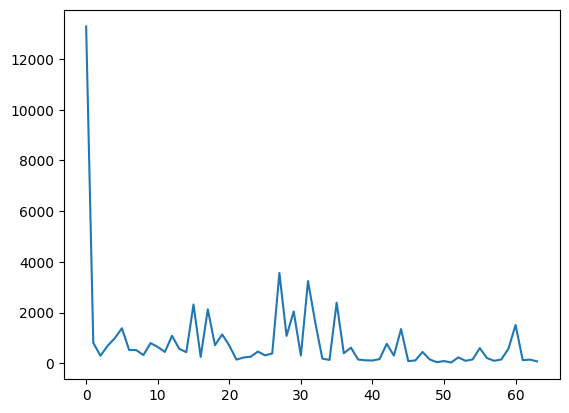

In [9]:
#plot the class frequencies 
import matplotlib.pyplot as plt 
freq = data['train_labels'].sum(axis=0)
# freq = get_class_frequencies_from_dataframe(
#             train_terms_df, data['top_terms']
#         )

plt.plot(freq)

In [11]:
def resample(data, train_terms_df, strategy='inv_freq', I=1000, t=0.5):

    class_frequencies = get_class_frequencies_from_dataframe(
            train_terms_df, data['top_terms']
        )
    sampled_idx = []
    if strategy == 'inv_freq':

        class_weights = 1.0 / (class_frequencies + 1e-6)

        R =(data['train_labels'] * class_weights).sum(axis=1)

    
        for i in range(I):
            k = np.random.choice(
                np.arange(len(data['top_terms']))
            )

            class_idx = np.where(data['train_labels'][:, k] == 1)[0]
            r = R[class_idx]
            r = r / r.sum()
            idx = np.random.choice(
                class_idx,
                p=r
            )
            sampled_idx.append(idx)
        
        return sampled_idx
        
    elif strategy == 'distribution_balanced':
        

        class_weights = 1.0 / (class_frequencies + 1e-6)
        p_i  = (data['train_labels'] * class_weights).sum(axis=1)

        for i in range(I):
            k = np.random.choice(
                np.arange(len(data['top_terms']))
            )
            p_c = class_weights[k]
            class_idx = np.where(data['train_labels'][:, k] == 1)[0]
            r =  p_c / p_i[class_idx]
            r = r / r.sum()
            idx = np.random.choice(
                class_idx,
                p=r
            )
            sampled_idx.append(idx)
        
        return sampled_idx
    
    elif strategy == 'log_pos':
        N = len(data['train_labels'])
        ep = 1e-3
        class_weights =  np.log(t * N / (class_frequencies + 1e-6))
        R  = (data['train_labels'] * class_weights).sum(axis=1)
        

        def reweight():
            """Update class frequencies based on sampled indices"""
            nonlocal class_weights, R
            up = 0.1
            # Get the current sampled labels
            sampled_labels = data['train_labels'][sampled_idx]
            
            # Compute class frequencies from sampled data
            sampled_class_freqs = sampled_labels.sum(axis=0)
            
            class_weights = np.log(t * N / (sampled_class_freqs + 1e-6))

            R = (data['train_labels'] * class_weights).sum(axis=1)

        for i in range(I):
            # Periodically reweight based on sampled indices
            # if i > 0 and i % 300 == 0:
            #     reweight()

            k = np.random.choice(
                np.arange(len(data['top_terms']))
            )
            class_idx = np.where(data['train_labels'][:, k] == 1)[0]
            r = R[class_idx]
            r = r - r.min() + ep
            r = r / r.sum()
            idx = np.random.choice(
                class_idx,
                p=r
            )
            sampled_idx.append(idx)
    
        return sampled_idx

In [12]:
sampled_idx = resample(data, train_terms_df, strategy='inv_freq', I=51000)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape   

(51000, 64)

In [13]:
#check unique index in sampled_idx
print(len(data['train_labels']))
print(len(np.unique(sampled_idx)))

38724
14751


In [14]:
idx = np.arange(0, len(data['train_labels']))
#check which indexes are not in sampled idx

np.setdiff1d(idx, sampled_idx)


array([    0,     2,     3, ..., 38721, 38722, 38723], shape=(23973,))

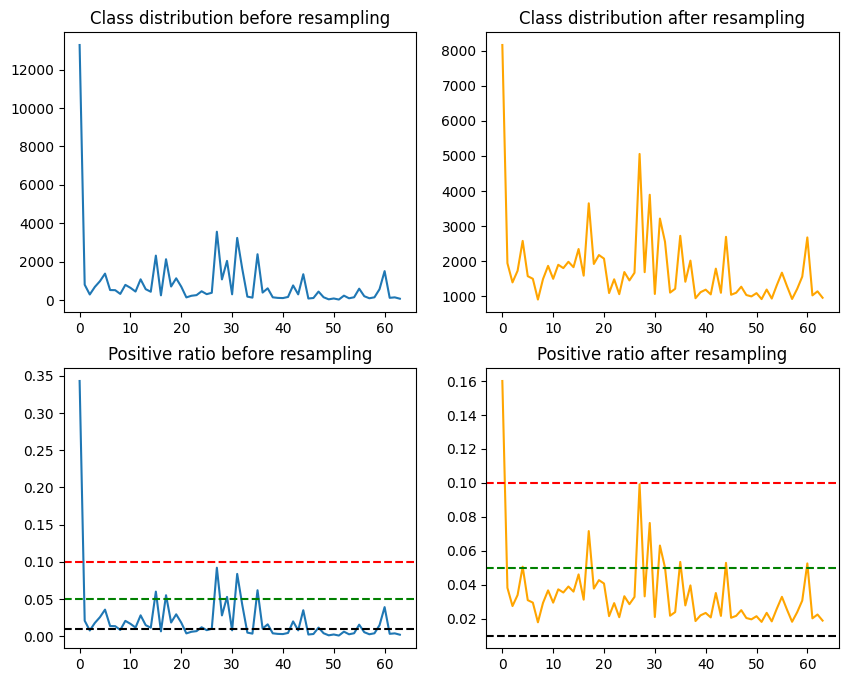

In [15]:
#plot the class distribution before and after resampling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)

ax[1, 0].plot(pos_ratio_before)
#create a line a y=0.1 and 0.05
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
ax[1, 1].set_title('Positive ratio after resampling')
plt.show()  

In [16]:
sampled_idx = resample(data, train_terms_df, strategy='distribution_balanced', I=51000)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape   

unique_idx, counts = np.unique(sampled_idx, return_counts=True)
print(len(unique_idx))
print(counts.max())

20479
40


In [17]:
diff = np.setdiff1d(idx, sampled_idx)
print(diff)

print(data['train_labels'][unique_idx[counts.argmax()]], '\n')
print(data['train_labels'][diff[0]], '\n')
print(data['train_labels'][diff[1]],  '\n')


[    2     3     4 ... 38715 38720 38723]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



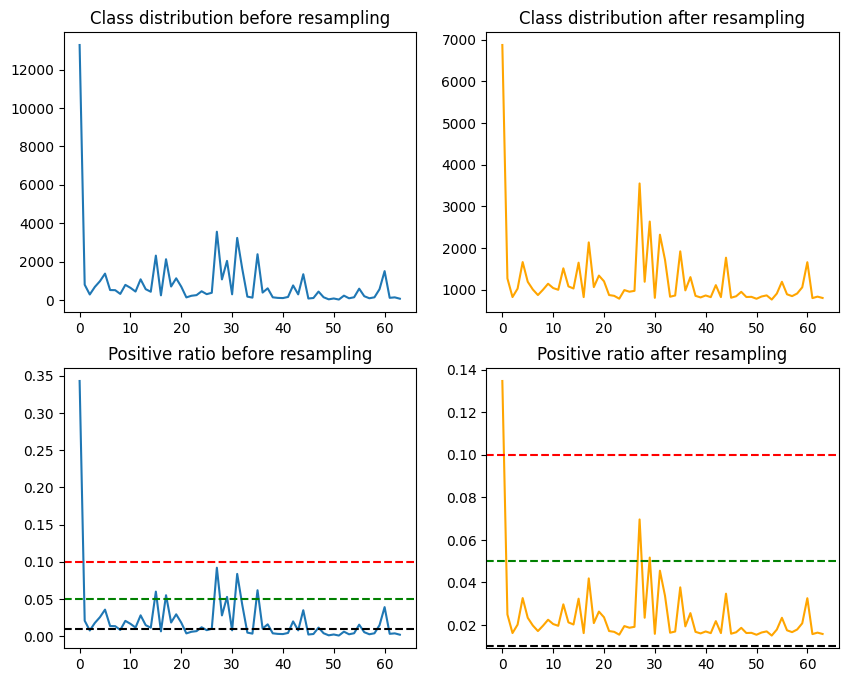

In [18]:
#plot the class distribution before and after resampling
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)
ax[1, 0].plot(pos_ratio_before)
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')

ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].set_title('Positive ratio after resampling')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
plt.show()  

In [20]:
sampled_idx = resample(data, train_terms_df, strategy='log_pos', I=51000, t=0.3)
sampled_train_labels = data['train_labels'][sampled_idx]
sampled_train_labels.shape    

(51000, 64)

In [21]:
unique_idx, counts = np.unique(sampled_idx, return_counts=True)
print(len(unique_idx))
print(counts.max())

diff = np.setdiff1d(idx, sampled_idx)
print(diff)

print(data['train_labels'][unique_idx[counts.argmax()]], '\n')
print(data['train_labels'][diff[0]], '\n')
print(data['train_labels'][diff[1]],  '\n')


8753
168
[    0     1     2 ... 38721 38722 38723]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



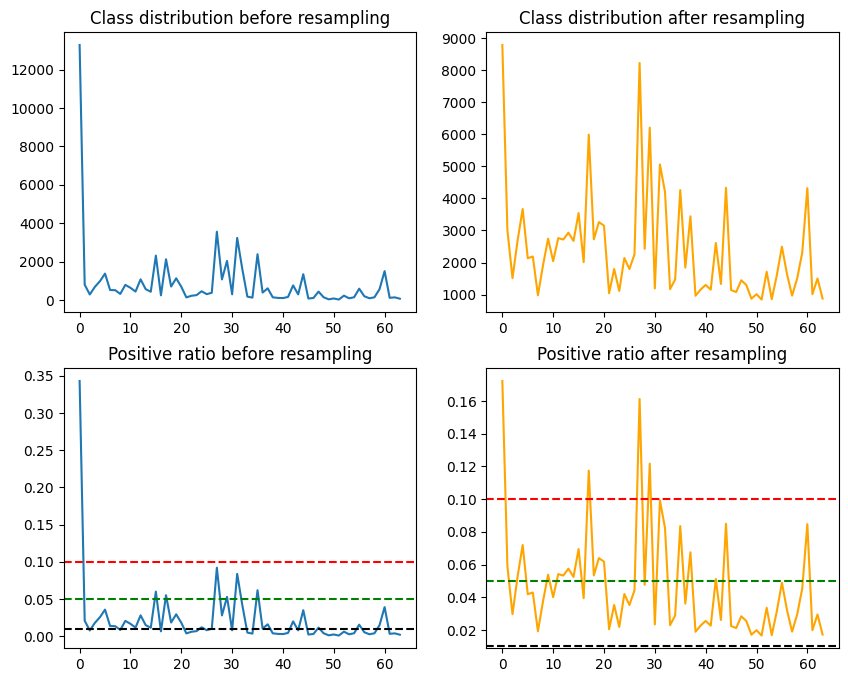

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(data['train_labels'].sum(axis=0))
ax[0, 0].set_title('Class distribution before resampling')
ax[0, 1].plot(sampled_train_labels.sum(axis=0), color='orange')
ax[0, 1].set_title('Class distribution after resampling')

#plot the ratio of positive samples per class before and after resampling
pos_ratio_before = data['train_labels'].sum(axis=0) / len(data['train_labels'])
pos_ratio_after = sampled_train_labels.sum(axis=0) / len(sampled_train_labels)
ax[1, 0].plot(pos_ratio_before)
ax[1, 0].set_title('Positive ratio before resampling')
ax[1, 0].axhline(y=0.1, color='r', linestyle='--')
ax[1, 0].axhline(y=0.05, color='g', linestyle='--')
ax[1, 0].axhline(y=0.01, color='black', linestyle='--')

ax[1, 1].plot(pos_ratio_after, color='orange')
ax[1, 1].set_title('Positive ratio after resampling')
ax[1, 1].axhline(y=0.1, color='r', linestyle='--')
ax[1, 1].axhline(y=0.05, color='g', linestyle='--')
ax[1, 1].axhline(y=0.01, color='black', linestyle='--')
plt.show()  

In [23]:
len(data['train_labels'])

38724